In [45]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.transforms as transforms
import numpy as np
import casadi as ca

In [2]:
from lib.control import *

In [319]:
def xy_heading(pos1, pos2):
    diff = pos2 - pos1
    return wrap_angle_360(np.degrees(np.arctan2(diff[1], diff[0])))

In [327]:
def wrap_angle_360(angle):
    if angle < 0:
        angle += 360
    return angle % 360

In [495]:
class LandingArea:
    def __init__(
        self,
        origin=[0, 0],
        width=10,
        height=10,
        rot=0,
        wind_spd=0,
        wind_dir=0,
        airspeed=14,
        flare_sink=1,
        max_sink=4,
        init_h=40,
        flare_h=3,
        safety_h=20
    ):
        self.origin = np.array(origin)
        self.width = width
        self.height = height
        self.rot = rot
        self.wind_spd = wind_spd
        self.wind_dir = wind_dir
        self.airspeed=airspeed
        self.flare_sink = flare_sink
        self.max_sink = max_sink
        self.init_h = init_h
        self.flare_h = flare_h
        self.safety_h = safety_h
        
        rot_rad = np.radians(rot)
        self.width_dir = np.array([np.cos(rot_rad), np.sin(rot_rad)])
        self.height_dir = np.array([-np.sin(rot_rad), np.cos(rot_rad)])
        self.center = self.origin + self.width/2*self.width_dir
        self.center += self.height/2*self.height_dir
        
        origin_hdg = xy_heading(self.origin, self.center)
        h_corner = self.origin + self.height*self.height_dir
        h_corner_hdg = xy_heading(h_corner, self.center)
        if h_corner_hdg > origin_hdg:
            self.h_hdg_interval = [origin_hdg, h_corner_hdg]
        else:
            self.h_hdg_interval = [h_corner_hdg, origin_hdg]
            
        self.includes_360 = False
        if self.h_hdg_interval[1] - self.h_hdg_interval[0] > 90:
            self.includes_360 = True
    
    def _height_collision(self, hdg):
        inv_hdg = wrap_angle_360(hdg+180)
        interval = self.h_hdg_interval
        if self.includes_360:
            return (hdg < interval[0] or hdg > interval[1]) or (inv_hdg < interval[0] or inv_hdg > interval[1])
        else:
            return (hdg > interval[0] and hdg < interval[1]) or (inv_hdg > interval[0] and inv_hdg < interval[1])
    
    def _hdg_line(self, hdg):
        hdg_rad = np.radians(hdg)
        return [self.center, self.center + np.array([np.cos(hdg_rad), np.sin(hdg_rad)])]
    
    def _height_lines(self):
        l1 = [
            self.origin,
            self.origin + self.height*self.height_dir
        ]
        l2 = [
            self.origin + self.width*self.width_dir,
            self.origin + self.width*self.width_dir + self.height*self.height_dir
        ]
        return l1, l2
        
    def _width_lines(self):
        l1 = [
            self.origin,
            self.origin + self.width*self.width_dir
        ]
        l2 = [
            self.origin + self.height*self.height_dir,
            self.origin + self.width*self.width_dir + self.height*self.height_dir
        ]
        return l1, l2
    
    def _intersection(self, l1, l2):
        pa, pb = l1
        pc, pd = l2
        
        a1 = pb[1] - pa[1]
        b1 = pa[0] - pb[0]
        c1 = a1*pa[0] + b1*pa[1]
        
        a2 = pd[1] - pc[1]
        b2 = pc[0] - pd[0]
        c2 = a2*pc[0] + b2*pc[1]
        
        det = a1*b2 - b1*a2
        if det == 0:
            print("error: parallel lines!")
            return
        x = (b2*c1 - b1*c2)/det
        y = (a1*c2 - a2*c1)/det
        return np.array([x, y])
    
    def plot(self, ax=None):
        if ax is None:
            _, ax = plt.subplots()
        patch = patches.Rectangle(
            (self.origin[0],self.origin[1]),
            self.width,
            self.height,
            self.rot,
            fill=False
        )
        ax.add_patch(patch)
        ax.scatter(self.center[0], self.center[1])
        ax.set_xlim([-20, 20])
        ax.set_ylim([-20, 20])
        ax.axis('equal')
        
    def plot_intersections(self, hdg, ax=None):
        if ax is None:
            _, ax = plt.subplots()
        p1, p2 = self.intersection_points(hdg)
        ax.scatter([p1[0], p2[0]], [p1[1], p2[1]], color='green')
        
    def groundspeed(self, hdg):
        hdg_rad = np.radians(hdg)
        wind_dir_rad = np.radians(self.wind_dir)
        wca = -np.arcsin(self.wind_spd/self.airspeed*np.sin(wind_dir_rad - hdg_rad)) + hdg_rad
        airspeed_vec = self.airspeed*np.array([np.cos(wca), np.sin(wca)])
        wind_vec = self.wind_spd*np.array([np.cos(wind_dir_rad), np.sin(wind_dir_rad)])
        return norm(airspeed_vec + wind_vec)
    
    def intersection_points(self, hdg):
        if self._height_collision(hdg):
            l1, l2 = self._height_lines()
        else:
            l1, l2 = self._width_lines()
        hdg_line = self._hdg_line(hdg)
        p1 = self._intersection(hdg_line, l1)
        p2 = self._intersection(hdg_line, l2)
        return p1, p2
    
    def feasible_heading(self, hdg):
        v = self.groundspeed(hdg)
        flare_dist = self.flare_h*v/self.flare_sink
        print('flare dist: {}'.format(flare_dist))
        approach_dist = (self.safety_h - self.flare_h)*v/self.max_sink
        print('approach: {}'.format(approach_dist))
        p1, p2 = self.intersection_points(hdg)
        max_dist = norm(p1-p2)
        print('total: {}'.format(flare_dist + approach_dist))
        print('max: {}'.format(max_dist))
        return flare_dist + approach_dist < max_dist
    
    def opti_params(self, hdg):
        v = self.groundspeed(hdg)
        p1, p2 = self.intersection_points(hdg)
        h_s = self.safety_h - self.flare_h
        h_0 = self.init_h - self.flare_h
        R_flare = self.flare_h*v/self.flare_sink
        R_c = norm(p1 - self.center)
        v_z_max = self.max_sink
        return {
            'v': v,
            'h_s': h_s,
            'h_0': h_0,
            'R_f': R_flare,
            'R_c': R_c,
            'v_z_max': v_z_max
        }

flare dist: 28.33455088510115
approach: 40.1406137538933
total: 68.47516463899444
max: 100.00000000000021
True


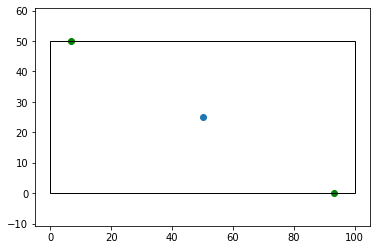

In [496]:
la = LandingArea(
    origin=[0, 0],
    width=100,
    height=50,
    rot=0,
    wind_spd=5,
    wind_dir=0
)
_, ax = plt.subplots()
hdg=150
la.plot_intersections(hdg, ax)
la.plot(ax)
print(la.feasible_heading(hdg))

In [497]:
params = la.opti_params(150)
opti = ca.Opti()
R_a = opti.variable()
R_b = opti.variable()

opti.subject_to(R_a >= 0)
opti.subject_to(R_b >= 0)
vz = params['h_0']*params['v']/(R_a - R_b - params['R_f'])
opti.subject_to(vz <= params['v_z_max'])
crossing_h = (R_a-2*params['R_c'])*vz/params['v']
opti.subject_to(crossing_h <= .75*params['h_s'])

opti.set_initial(R_a, 100)
opti.set_initial(R_b, 50)

opti.minimize((R_b-params['R_c'])**2)

In [498]:
opti.solver('ipopt')
sol = opti.solve()

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        6
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        2

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [499]:
opti.value(crossing_h)

12.750000127485093

In [500]:
(opti.value(R_a) - opti.value(R_b) - params['R_f'])*opti.value(vz)/params['v']

37.0

In [501]:
print(opti.value(R_a))
print(opti.value(R_b))

130.1054603154035
14.4060450748354


In [502]:
opti.value(vz)

4.000000039997541